# The Kinetics of a Diffusion-Controlled Reaction
## Brandon Cohen
### March 20, 2023


## Purpose
The purpose of this lab is to use fluorescence quenching to determine the rate constant and collision diameter using anthracene and carbon tetrabromide.

## Procedure

A 250 mL of 1.00e-4 M solution of anthracene using n-hexane and a 25 mL of 1.50e-2 CBr4 was prepared. Eight dilutions of AN/CBr4 was created consisting of 5%, 15%, 35%, 50%, 60%, 70%, 80%, and 90% CBr4 solution as well as a 0% and 100% solution. For each sample, the solution was put into a fluorescence cell covered with aluminum foil and deaerted with N2 for around 2 minutes. The excitation wavelength used was 283 nm and the emission wavelength was 350 nm to 550 nm with a slit width of 2.5 nm. Each solution was measured using a spectrofluormeter to find a full fluorescence emission spectrum. Then, the data was analyzed using Python. A Stern-Volmer graph was plotted and k_1 was calculated. The collision radius (R) was calculated and a straight line was superimposed onto the Stern-Volmer plot using k_1.Ignoring the transient term, a trendline was fitted using points close to [Q] = 0 to find an alternate value of k_1 as well as another collision radius value. The data was then examined using all of the data including effects due to the transient-term to find another collision value.

In [1]:
# File handling
from pathlib import Path
from shutil import unpack_archive
import re

# Data manipulation
import numpy as np
import scipy as sp
from scipy import special
import pandas as pd
import math

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
sns.despine()

/tmp/ipykernel_533653/171839487.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<Figure size 640x480 with 0 Axes>

# Data import
We retrieve all the required data for the analysis.

In [2]:
# Unzip the fluorescence data into a subfolder
filename = Path("bc_fl_data" + ".zip") # fill in the name of the file without the ZIP extension
dest_folder = Path("F") # fill in a name for a subfolder in which to place the text files
unpack_archive(filename, dest_folder)

In [3]:
# Import all of the files in your new folder. 
# If your files end in something other than ".TXT", make that change here
all_files = list(dest_folder.glob("*.TXT"))

li = [] # Create an empty list to hold the contents of our assorted files
# Import each file in order
# Skip first 31 rows, as data doesn't start until line 32
# Set first (0-th) column (nm) as index
# Default file from fluorometer uses tabs (\t) for separators
for file in all_files:
    df = pd.read_csv(file, skiprows=31, index_col=0, sep='\t') 
    li.append(df)

raw_spectra = pd.concat(li, axis=1) # Use `axis=1` to turn rows of list into columns of dataframe
for file in all_files:
    print(file) # List filenames so we can figure out our column naming in the next step. 
    
raw_spectra.head() # Display the top five rows of our dataframe

F/CBr4_70pct(FDS).TXT
F/CBr4_5pct(FDS).TXT
F/CBr4_50pct(FDS).TXT
F/CBr4_15pct(FDS).TXT
F/CBr4_80pct(FDS).TXT
F/CBr4_60pct(FDS).TXT
F/CBr4_00pct(FDS).TXT
F/CBr4_100pct(FDS).TXT
F/CBr4_90pct(FDS).TXT
F/CBr4_35pct(FDS).TXT


Data    Data   Data   Data   Data   Data   Data   Data   Data   Data
nm                                                                          
350.0  2.025  125.20  3.960  32.40  1.604  2.227  263.0  0.498  1.007  8.681
350.5  1.812  114.90  3.905  29.97  1.563  2.200  243.2  0.482  1.074  8.290
351.0  1.777  104.10  3.684  27.55  1.514  2.119  221.8  0.421  1.060  7.223
351.5  1.805   93.27  3.457  24.72  1.512  1.900  199.2  0.520  1.010  6.456
352.0  1.852   86.13  2.962  23.50  1.479  1.924  180.9  0.316  1.014  6.040

In [4]:
# Here, we use the `re` (Regular Expressions) library to search for patterns in text
# Specifically, we're going to look for the percentage numbers in our filenames. This assumes
# your filenames have a two or three digit number representing the AN percent in your samples.
cols = []
for file in all_files:
    # The next line looks for two or 3 digits in a row, assuming you've placed 
    # the concentration in your file names.
    # You may need to change this pattern, ask for help
    _val = re.findall(r'\d{1,3}',file.stem)[1]
    _val = int(_val)
    
    # This line turns the AN percent into a CBr4 percent. 
    # Modify it if you recorded the CBr4 value.
    cols.append(_val) 
    
cols # This is just to check for reasonable values. Order isn't important.

[70, 5, 50, 15, 80, 60, 0, 100, 90, 35]

In [5]:
# Assign the column labels to your dataframe columns, plot the spectra. 
# Make sure your spectra decrease in intensity from 0%‚Äì100% CBr4
raw_spectra.columns = cols
raw_spectra.plot()
print("Figure 1: Spectrum of Each Dilution")

Figure 1: Spectrum of Each Dilution


# Data processing
Put here the core of the notebook. Feel free to further split this section into subsections.

In [6]:
1/raw_spectra.max()

70     0.040323
5      0.000860
50     0.017479
15     0.002293
80     0.050201
60     0.033647
0      0.000538
100    0.098619
90     0.091659
35     0.007855
dtype: float64

In [7]:
# Compile a sorted list of maximum intensities from each of our spectra
# The first line grabs the largest value from each spectrum, 
# then divides the largest value in that list by each maximum (calculating I_0/I)
intensities = raw_spectra.max().max()/raw_spectra.max() 

# Now we sort the list of values and convert it to a dataframe for display and plotting
intensities = intensities.sort_index().to_frame()
intensities.columns = ['Intensity'] # Add a proper label to the column
print("Table 1. Concentration with Respective Intensity")
intensities

Table 1. Concentration with Respective Intensity


Intensity
0      1.000000
5      1.599312
15     4.265077
35    14.611155
50    32.511799
60    62.584118
70    75.000000
80    93.373494
90   170.485793
100  183.431953

Figure 2. Stern-Volmer Plot of Experimental Data


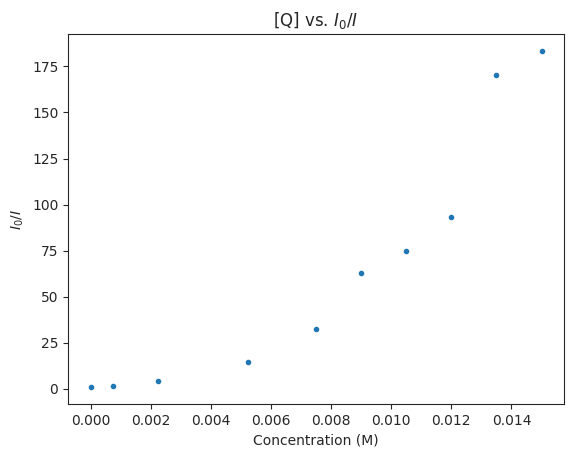

In [8]:
# This is an example of a simple function with a "docstring". 
# When writing code, docstrings provide a simple way to document
# the purpose of a function within your code. When a user calls 
# `help(func)` on your function, the docstring will pull up and 
# tell the user how to proceed. 
def p2f(x): 
    '''Convert percentage to floating point numbers'''
    return float(x)/100

init_conc =  0.0150 

# The next line uses "list comprehension" to apply a function to each item in a list.
# We convert the index object to a list, then convert each string to a fractional value with p2f, 
# then multiply each fraction by the original concentration
intensities['Concentration (M)'] = [(p2f(item) * init_conc) for item in intensities.index.to_list()]

print("Figure 2. Stern-Volmer Plot of Experimental Data")
plt.plot(intensities['Concentration (M)'], intensities['Intensity'], '.')
plt.xlabel('Concentration (M)')
plt.ylabel('$I_0/I$') 
plt.title('[Q] vs. $I_0/I$') # wrapping the input in `$` turns it into LaTeX math
plt.show()


### Collision radius via SES equation

In [9]:
# Variable setup
# You'll need to create variables for the assorted values you'll use in 
# your calculations (e.g., tau_0, D, etc.)
R = 8314.77
T = 298.15
eta_hex = 0.0002949
eta_hep = 0.0003890
N_A = 6.0221408e23
tau_0 = 5.52e-9

In [10]:
## SES: 
#    k = (8 * R_gas * T) / (3 * \eta)
#    k =  4 * \pi * N_A * radius * D / 1000

D = (eta_hep/eta_hex) * 4.35e-5
k_ses = (8 * R * T) / (3 * eta_hex)


# Can format numbers with the `:#.#g` syntax. `g` is an auto-formatter for 
# numbers that automatically trims and converts to scientific form if necessary. 
print(f"The reaction constant with the SES equation is {k_ses:g} 1/(M*s).") 

# Now calculate the radius
radius_ses = (k_ses * 1000) / (4 * np.pi * D * N_A)
print(f"The reaction radius is {radius_ses:g} dm")

The reaction constant with the SES equation is 2.24171e+10 1/(M*s).
The reaction radius is 5.16243e-08 dm


### Collision radius via SES equation

In [11]:
## SES: k = (8 * R * T) / (3 * \eta)

print(f"The reaction constant with the SES equation is {k_ses:g} 1/(M*s).") 

#radius_ses = 
print(f"The reaction radius is {radius_ses:g} dm")

The reaction constant with the SES equation is 2.24171e+10 1/(M*s).
The reaction radius is 5.16243e-08 dm


Figure 3. Stern-Volmer Plot with Linear Model


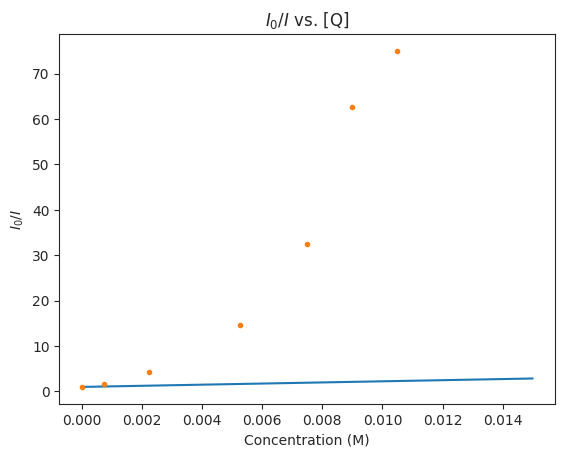

In [12]:
# Now we need to plot a line based on the SES calculations

# We start by making a range of concentration values. 
# `linspace` is an ideal function as it makes evenly spaced 
# points between the start and stop values (50, by default). 
conc_data = np.linspace(0.000,0.015)

xdata = conc_data
ses_fit = tau_0 * k_ses * xdata + 1

print("Figure 3. Stern-Volmer Plot with Linear Model")
plt.plot(xdata,ses_fit,'-',
        intensities["Concentration (M)"][:7], intensities["Intensity"][:7], ".")
plt.xlabel('Concentration (M)')
plt.ylabel('$I_0/I$')
plt.title('$I_0/I$ vs. [Q]')
plt.show()


### Collision radius via Stern-Vollmer relation (no transient term)

Figure 4. Linear Fit of the First 4 Points from Figure 2


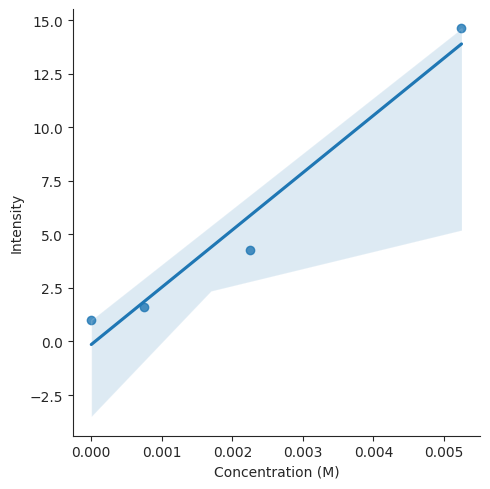

In [13]:
# We're supposed to look at a linear fit for just the first few points. 
# Seaborn's `lmfit` is a good tool for this. By changing the number of 
# points used from intensities, you can see how the fit degrades as you 
# use more points. Change the value of `4` to smaller and larger numbers 
# and see how the fit changes
sns.lmplot(data=intensities[:4],x="Concentration (M)", y="Intensity")
print("Figure 4. Linear Fit of the First 4 Points from Figure 2")

In [14]:
# Again, we need to make a linear fit of the data, so we'll 
# use the polyfit function from numpy. 
fit_coeff, fit_cov = np.polyfit(intensities["Concentration (M)"][:4], intensities["Intensity"][:4], 1, cov=True)

fit_err = np.sqrt(np.diag(fit_cov))

print(f"slope: {fit_coeff[0]/tau_0:1.4g}, std. err.: {fit_err[0]/tau_0:g}\n\
intercept: {fit_coeff[1]:g}, std. err.: {fit_err[1]:g}")
radius_fit = fit_coeff[0]/tau_0 * 1000 / (4 * sp.constants.Avogadro  * np.pi * D )
print(f"The reaction radius is {radius_fit:g} dm")

slope: 4.841e+11, std. err.: 6.73833e+10
intercept: -0.142103, std. err.: 1.07139
The reaction radius is 1.11473e-06 dm


In [15]:
# We'll compare the fit from the previous method to one using the curve_fit 
# routine from scipy.optimize. In your summary, comment on the differences 
# (and why they exist). The key is in the y-intercept‚Ä¶

def sv_func(conc, k_q):
    return (k_q * tau_0 * conc) + 1


from scipy.optimize import curve_fit

# Need to provide initial guess for parameter‚Ä¶
sv_coeff, sv_cov = curve_fit(sv_func, intensities["Concentration (M)"][:4], intensities["Intensity"][:4], p0=2e10)

sv_err = np.sqrt(np.diag(sv_cov))

print(sv_coeff, "\n", sv_err)
radius_sv = sv_coeff[0] * 1000 / (4 * sp.constants.Avogadro  * np.pi * D )
print(f"The reaction radius is {radius_sv:g} dm")

[4.3262354e+11] 
 [4.80946834e+10]
The reaction radius is 9.96289e-07 dm


In [16]:
def a(R, conc):
    return ( (1/tau_0) + ( (4 * np.pi * R * D * sp.constants.Avogadro / 1000) * conc ) )

def b(R, conc):
    return (4 * np.sqrt(np.pi * D) * R**2 * sp.constants.Avogadro * conc / 1000)

def y_const(R, conc):
    term1 = b(R, conc) * np.sqrt(np.pi) / a(R, conc)
    term2 = np.exp( b(R, conc)**2 / a(R, conc) )
    term3 = special.erfc( b(R, conc) / np.sqrt(a(R, conc)) )
    return 1 - (term1*term2*term3)

R = 2.70741e-06 ¬± inf cm
Figure 5. Stern-Volmer Plot of Experimental Data including Transient Terms


/home/jupyter-brandonc/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_533653/3281881970.py:6: OptimizeWarning: Covariance of the parameters could not be estimated
  sv_coeff_2 , sv_cov_2 = curve_fit(intensity,


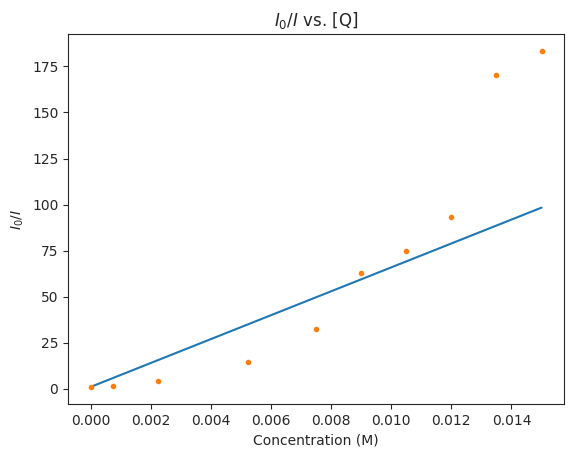

In [17]:
def intensity(conc, R):
    return ( 1 + ( (4 * np.pi * R * D * sp.constants.Avogadro / 1000) * conc * tau_0) ) / y_const(R, conc)
           # fill in the equation for the intensity (I_0/I) as a function
           # of conc, R, and y_const(conc, R)

sv_coeff_2 , sv_cov_2 = curve_fit(intensity, 
                                  intensities["Concentration (M)"], 
                                  intensities["Intensity"], 
                                  p0= [radius_ses]# Enter an initial guess for the parameters (just R, in cm, in this case)
                                 )

sv_err_2 = np.sqrt(np.diag(sv_cov_2))

print(f"R = {sv_coeff_2[0]:g} ¬± {sv_err_2[0]:.2e} cm")

# Create a plot that shows your fit compared to the experimental data
print("Figure 5. Stern-Volmer Plot of Experimental Data including Transient Terms")
plt.plot(xdata,intensity(xdata, sv_coeff_2[0]),'-',
        intensities["Concentration (M)"], intensities["Intensity"], ".")
plt.xlabel('Concentration (M)')
plt.ylabel('$I_0/I$')
plt.title('$I_0/I$ vs. [Q]')
plt.show()


## Results and Discussion
Using the Stokes-Einstein-Simoluchowski (SES) equaiton, the reaction constant (k_1) was 2.24171e+10 1/(M*s), and the reaction radius was 5.16243e-08 dm. Using the full Stern-Volmer relation with transient terms, R = 4.69047e-07 ¬± 8.72e-09 cm. Using the linear fit from Figure 3, the calculated reaction radius was 1.11473e-06 dm. The linear fit showed that as concentration increased, the intensity also increased. Using the curve_fit function from scipy.optimize, the calculated reaction radius was 9.96289e-07 dm. There is an order of magnitude of over 10 between the two calculated reaction radius. Based on both of their standard errors, the curve_fit function had a smaller standard error so it should provide a better approximation for the reaction radius instead of the linear_fit. This is probably because the first four points are not fully linear. Based on the four calculated R values, the R values from the SES equation and the full Stern-Volmer relation with transient terms are close in value in relation to the scipy.optimize R calculated value and the linear fit R value which are much further away and are not within range. This shows the full Stern-Volmer with transient terms and the SES equation are adequate to calculate the R value. 

Anthracene fluorescence quenching is diffusion-controlled rather than chemical-controlled because the $k_{obs}$ is equal to $k_1$ which also means that the encounter complex between anthracene and carbon tetrabromide undergoes rapid deactivation giving rise to the steady-state approximation. The quenching mechanism involves electron transfer from anthracene to $CBr_4$, but the reaction is limited by the diffusion of anthracene and $CBr_4$ in the solvent. An experiment that could be performed to determine whether a stable photoproduct was formed as a result of fluorescence quenching would be by performing an experiment such as NMR to determine the structures of all species in solution and then performing the same experiment above in complete darkness. The luminescence can be timed and then another NMR experiment can be performed. The lifetime of the excited anthracene has to be a small time which will confirm it is not phosphorescence. Performing the NMR experiment will tell if the species in the solution are the same. If they are not the same, then this may be due to a chemiluminescence reaction instead of fluorescence. If $Y=1$ in eq. 15, then $k_q \rightarrow k_1$. This connection can be made when taking the limit of k_1 as time approaches infinity from eq. 10. When observing eq. 15, it is seen that the right side result of eq. 10 can be found in eq. 15 on the right side of the equation. When comparing eq. 14 and eq. 15, it can also be seen that they are equivalent when rearranging the +1 in eq. 15 from the right side to the left side. From eq. 14 and 15, $k_q$ was determined to be equivalent to $4 \pi ùëÖùê∑ùëÅ_A/1000$, and it was already shown above that the limit of $k_1$ as time approaches infinity equals this term as time approaches infinity from eq. 10, so this implies that $k_q \rightarrow k_1$. If a polar solvent such as acetonitrile is used in the solution, then it will cause errors in the results because acetonitrile is also a quencher which means it will react during excited-state interactions. This means anthracene can react with $CBr_4$ or acetonitrile to form an encounter complex, but the problem is that when measuring fluorescence, there should not be too much quencher used due to the potential of static quenching. 